## Import data
Load buffers, road network, and habitat data from files.

The habitats data is in CSV format, each entry represents a habitat within a buffer, with the following properties
- `buffer_id`: ID of the buffer to which the habitat belongs
- `TypoCH`: Swiss TypoCH habitat type code
- `habitat_area`: Area of the habitat within the buffer in square meters
- `percentage`: Percentage of the buffer area that is covered by this habitat type

The road data is also in CSV format, with the following properties:
- `buffer_id`: ID of the buffer to which the road segment belongs
- `avg_speed`: Average speed limit of the road segment in km/h
- `max_lanes`: Maximum number of lanes on the road segment
- `is_tunnel`: Boolean indicating whether the road segment is a tunnel

In [1]:
import geopandas as gpd
import pandas as pd
from src.utils import get_habitat_name, most_common_habitat, create_fragmentation_index, get_dominant_habitats, create_pie_chart, create_habitat_palette

buffers = gpd.read_file("../data/buffers/A9_buffers_250_500_200.geojson")
road = gpd.read_file("../data/road_networks/A9.gpkg")
habitats = pd.read_csv("../data/habitats/habitats_in_A9_buffers.csv")
road_data = pd.read_csv("../data/road_networks/road_data_in_A9_buffers.csv")
typoch_names = pd.read_csv('../data/habitats/typoCH_names.csv')

In [2]:
# import osmnx as ox
# from shapely.geometry import box
# # Crop the buffers to for the greater Lausanne area
# la_greater = ox.geocode_to_gdf("Lausanne, Switzerland")
# buffers = buffers.to_crs(la_greater.crs)
# minx, miny, maxx, maxy = 6.52, 46.45, 6.72, 46.62
# lausanne_bbox = box(minx, miny, maxx, maxy)
# bbox_gdf = gpd.GeoDataFrame({'geometry': [lausanne_bbox]}, crs="EPSG:4326")
# buffers_clipped = gpd.clip(buffers, bbox_gdf)
# buffers_clipped.to_file("../data/buffers/A9_buffers_lausanne.geojson", driver="GeoJSON")
# buffers = buffers_clipped

## Most common habitat types along road

In [3]:
most_common_habitat(habitats, typoch_names)


----- 10 Most common habitats by total area -----

8.2: Field crops, 14,881,787 m²
6.2: Beech Forests, 6,140,621 m²
9.3.2: Surfaced roads, 5,869,565 m²
9: Built habitats, 4,650,341 m²
4.5.1: Medio-European lowland hay meadows, 3,827,484 m²
8.1.6: Vineyards, 3,181,038 m²
4.0.1: Temporarily grasslands in rotated crops, 2,602,584 m²
4: Grasslands, 2,324,650 m²
9.2: Building, 2,088,400 m²
5.3: Scrubs, brushes and clearings, 1,750,380 m²


### Dominant Habitat Type in Each Buffer
For each buffer, get the TypoCH with the largest `habitat_area`


In [4]:
dominant_habitat = get_dominant_habitats(habitats)

# Merge the dominant habitat type back into the buffers GeoDataFrame
buffers = buffers.merge(dominant_habitat, on='buffer_id', how='left')

In [5]:
vals = dominant_habitat['dominant_typoch'].unique()
print(vals)
print(len(vals))

['8.2' '6.2' '9' '4.0.1' '4.2.4' '6.3.3' '8.1.6' '6.1.2' '4' '6.2.1'
 '4.5.1' '5.3' '9.3.2' '3.3' '6.3.1' '8.1' '1.1' '4.0.3' '6.2.3']
19


There are 19 habitat types that are dominant in the buffers along the A9 motorway in Vaud.

We also create a mapping of the dominant habitat type category to the name of the habitat type for easier interpretation.

In [6]:
# Add name of dominant habitat type to buffers
buffers['dominant_habitat_name'] = buffers['dominant_typoch'].apply(lambda x: get_habitat_name(typoch_names, x))

## Habitat Fragmentation within buffers
We determine a fragmentation index for each buffer, which is the number of unique habitat types present in that buffer. This gives an indication of habitat diversity and fragmentation.

In [7]:
# Count number of habitat types in each buffer
fragmentation_index = create_fragmentation_index(habitats)

# Merge the fragmentation index back into the buffers GeoDataFrame
buffers = buffers.merge(fragmentation_index, on='buffer_id', how='left')

In [8]:
print(f"maximum fragmentation in buffers: {max(fragmentation_index['fragmentation_index'])}")
print(f"minimum fragmentation in buffers: {min(fragmentation_index['fragmentation_index'])}")

maximum fragmentation in buffers: 32
minimum fragmentation in buffers: 7


Along the A9 motorway in Vaud, the maximum number of unique habitat types in a buffer is 32 and the minimum is 7, indicating that some buffers have a diverse range of habitats while others are more homogeneous.

## Visualization of buffers with habitat data

First, add road data to the buffers GeoDataFrame.

In [9]:
# Merge road data into buffers
buffers = buffers.merge(road_data[['buffer_id','avg_speed','max_lanes','is_tunnel']], on='buffer_id', how='left')

For each buffer, assign the dominant habitat type based on the largest area of that habitat within the buffer. This gives an idea of the most prevalent habitat type in each buffer.

In [10]:
# Verify that the data frame has: 'avg_speed', 'max_lanes', 'is_tunnel', 'fragmentation_index', 'dominant_typoch', 'dominant_habitat_name'
print(buffers.columns)

Index(['buffer_id', 'geometry', 'dominant_typoch', 'dominant_habitat_name',
       'fragmentation_index', 'avg_speed', 'max_lanes', 'is_tunnel'],
      dtype='object')


In [11]:
print(buffers.crs)
buffers = buffers.to_crs(epsg=4326)  # Convert to Swiss coordinate system

EPSG:2056


### Color palette for the dominant habitat types.
Each habitat type will be assigned a unique color, and we will use this to visualize the buffers on a map.

In [12]:
dom = buffers['dominant_typoch'].unique()

habitat_palette = create_habitat_palette(dom)

In [13]:
from src.utils import hex_to_rgba

buffers['color'] = buffers['dominant_typoch'].map(lambda t: hex_to_rgba(habitat_palette.get(t, '#CCCCCC'), alpha=100))

### Visualization

In [14]:
from src.buffers.data_in_buffers_visualization import visualize_buffers_habitat_data

visualize_buffers_habitat_data(buffers, "outputs/lausanne/a9_habitats_lausanne.html")
# for col in ['avg_speed', 'max_lanes', 'fragmentation_index']:
#     visualize_buffers_data(buffers, col, f"outputs/lausanne/a9_buffers_{col}.html")

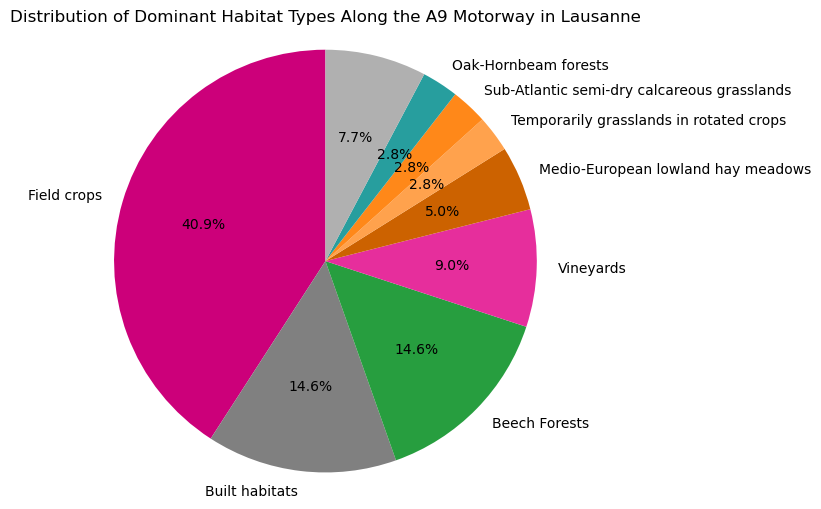

In [15]:
create_pie_chart(buffers['dominant_typoch'], habitat_palette, typoch_names, 'Distribution of Dominant Habitat Types Along the A9 Motorway in Lausanne')

## Road Categorization and Habitat Analysis

### Road Categorization
1. Tunnels
2. ?
3. ?

To find the other 2 categorues we perform a clustering analysis on the road segments that are not tunnels, using their average speed and maximum number of lanes as features. This will help us identify distinct groups of roads based on these attributes.

In [16]:
from src.utils import cluster_with_undersampling

non_tunnel, centroids = cluster_with_undersampling(buffers, n_clusters=3)

In [17]:
print("Means for each cluster (before labelling):")
print(non_tunnel.groupby('road_subcat')[['avg_speed', 'max_lanes']].mean())
print("\nCluster sizes:")
print(non_tunnel['road_subcat'].value_counts())

Means for each cluster (before labelling):
              avg_speed  max_lanes
road_subcat                       
0            119.373602   2.738255
1             82.584906   2.886792
2            104.775758   2.890909

Cluster sizes:
road_subcat
0    149
2     55
1     53
Name: count, dtype: int64


In [18]:
name_map = {
    0: "High-Speed Segment",
    1: "Lower-Speed Segment",
    2: "Medium-Speed Segment"
}
non_tunnel['road_subcat'] = non_tunnel['road_subcat'].map(name_map)

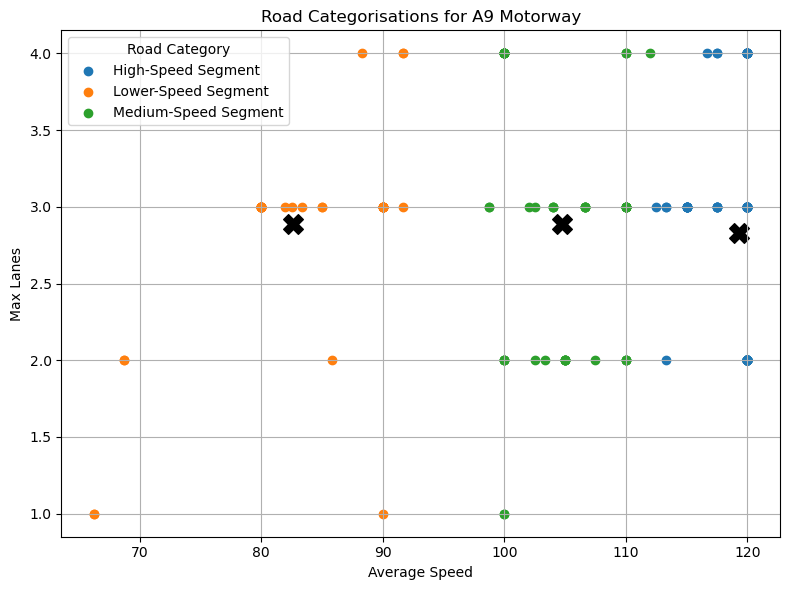

In [19]:
import matplotlib.pyplot as plt

categories = sorted(non_tunnel['road_subcat'].unique())
cmap = plt.get_cmap('tab10')


plt.figure(figsize=(8, 6))

# Plot each category separately so that legend colors match exactly
for idx, cat in enumerate(categories):
    subset = non_tunnel[non_tunnel['road_subcat'] == cat]
    plt.scatter(
        subset['avg_speed'],
        subset['max_lanes'],
        color=cmap(idx),
        label=cat
    )

# plot centroids
for idx, centroid in enumerate(centroids):
    label = name_map.get(idx, None)
    plt.scatter(
        centroid[0], centroid[1],
        marker='X',
        s=200,
        color='black',
        linewidths=1,
        label=None  # No legend entry for centroids
    )

plt.title('Road Categorisations for A9 Motorway')
plt.xlabel('Average Speed')
plt.ylabel('Max Lanes')
plt.grid(True)
plt.legend(title="Road Category")
plt.tight_layout()
plt.show()


In [20]:
# Assign "Tunnel" category
buffers['road_category'] = buffers['is_tunnel'].map({True: 'Tunnel'})
# Assign cluster labels to non-tunnel rows
buffers.loc[non_tunnel.index, 'road_category'] = non_tunnel['road_subcat']

# Print top-5 dominant habitats for each road category
for cat in buffers['road_category'].unique():
    print(f"\nCategory: {cat}")
    subset = buffers[buffers['road_category'] == cat]
    counts = subset['dominant_habitat_name'].value_counts()
    print(counts.head(5))



Category: High-Speed Segment
dominant_habitat_name
Field crops                           95
Built habitats                        13
Vineyards                             11
Beech Forests                          8
Medio-European lowland hay meadows     8
Name: count, dtype: int64

Category: Lower-Speed Segment
dominant_habitat_name
Beech Forests                                  13
Sub-Atlantic semi-dry calcareous grasslands     9
Field crops                                     8
Oak-Hornbeam forests                            8
Built habitats                                  7
Name: count, dtype: int64

Category: Tunnel
dominant_habitat_name
Beech Forests     21
Built habitats    20
Vineyards         12
Field crops        6
Surfaced roads     2
Name: count, dtype: int64

Category: Medium-Speed Segment
dominant_habitat_name
Field crops       23
Built habitats     7
Vineyards          6
Beech Forests      5
Surfaced roads     4
Name: count, dtype: int64


In [21]:
print(buffers['road_category'].value_counts(dropna=False))

road_category
High-Speed Segment      149
Tunnel                   66
Medium-Speed Segment     55
Lower-Speed Segment      53
Name: count, dtype: int64


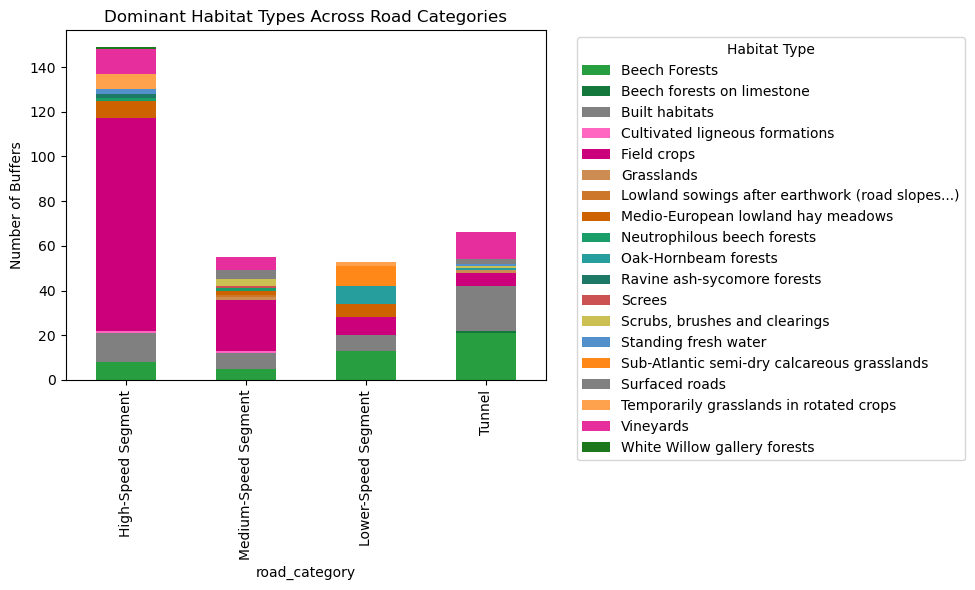

In [27]:
name_palette = {}
for code, hex_color in habitat_palette.items():
    name = get_habitat_name(typoch_names, code)
    if name is not None:
        name_palette[name] = hex_color

desired_order = ["High-Speed Segment", "Medium-Speed Segment", "Lower-Speed Segment", "Tunnel"]
ct = pd.crosstab(buffers['road_category'],buffers['dominant_habitat_name'])
ct = ct.reindex(desired_order)
colors = [ name_palette.get(habitat_name, "#B0B0B0") for habitat_name in ct.columns ]


# Plot
ct.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=colors
)
plt.ylabel('Number of Buffers')
plt.title('Dominant Habitat Types Across Road Categories')
plt.legend(title='Habitat Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


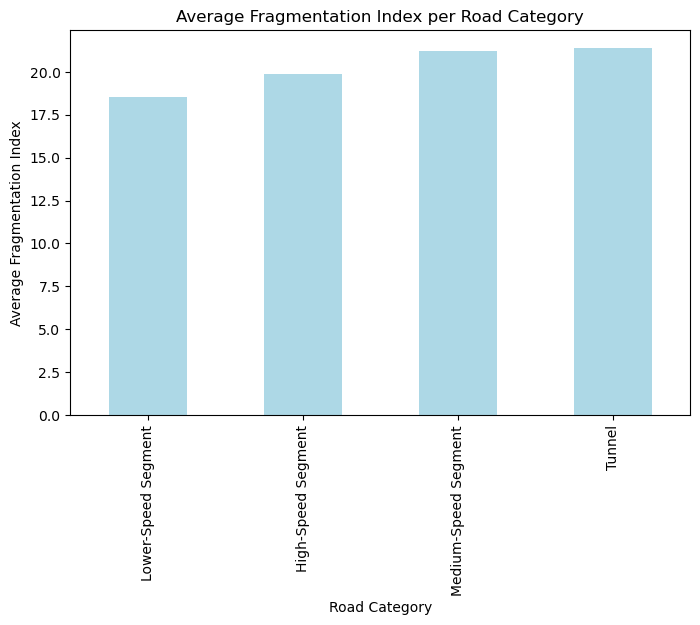

In [23]:
import matplotlib.pyplot as plt

# Compute the mean fragmentation index for each road category
mean_fragmentation = buffers.groupby('road_category')['fragmentation_index'].mean().sort_values()

# Plot
plt.figure(figsize=(8, 5))
mean_fragmentation.plot(kind='bar', color='lightblue')
plt.ylabel('Average Fragmentation Index')
plt.title('Average Fragmentation Index per Road Category')
plt.xlabel('Road Category')
# plt.tight_layout()
plt.show()


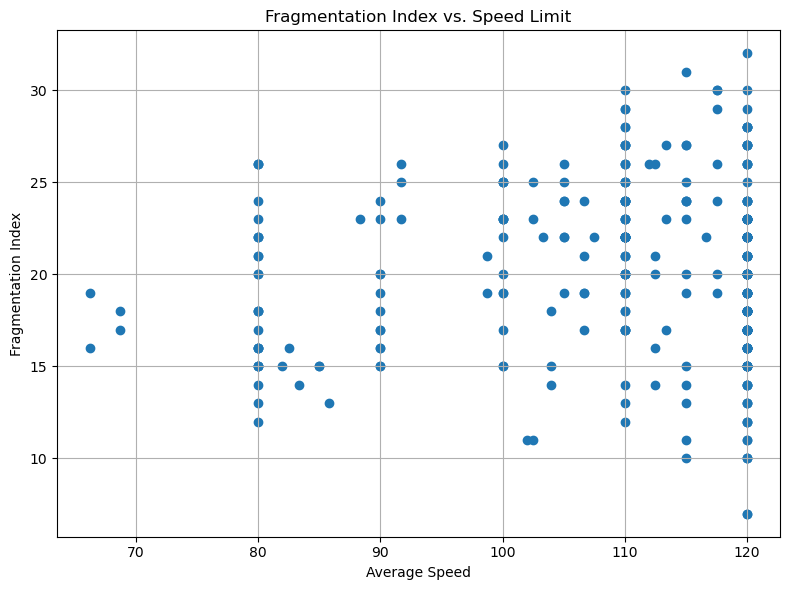

In [24]:
import matplotlib.pyplot as plt

# Scatter plot: fragmentation_index vs. avg_speed (speed limit)
plt.figure(figsize=(8, 6))
plt.scatter(
    buffers['avg_speed'],
    buffers['fragmentation_index'],
)
plt.xlabel('Average Speed')
plt.ylabel('Fragmentation Index')
plt.title('Fragmentation Index vs. Speed Limit')
plt.grid(True)
plt.tight_layout()
plt.show()


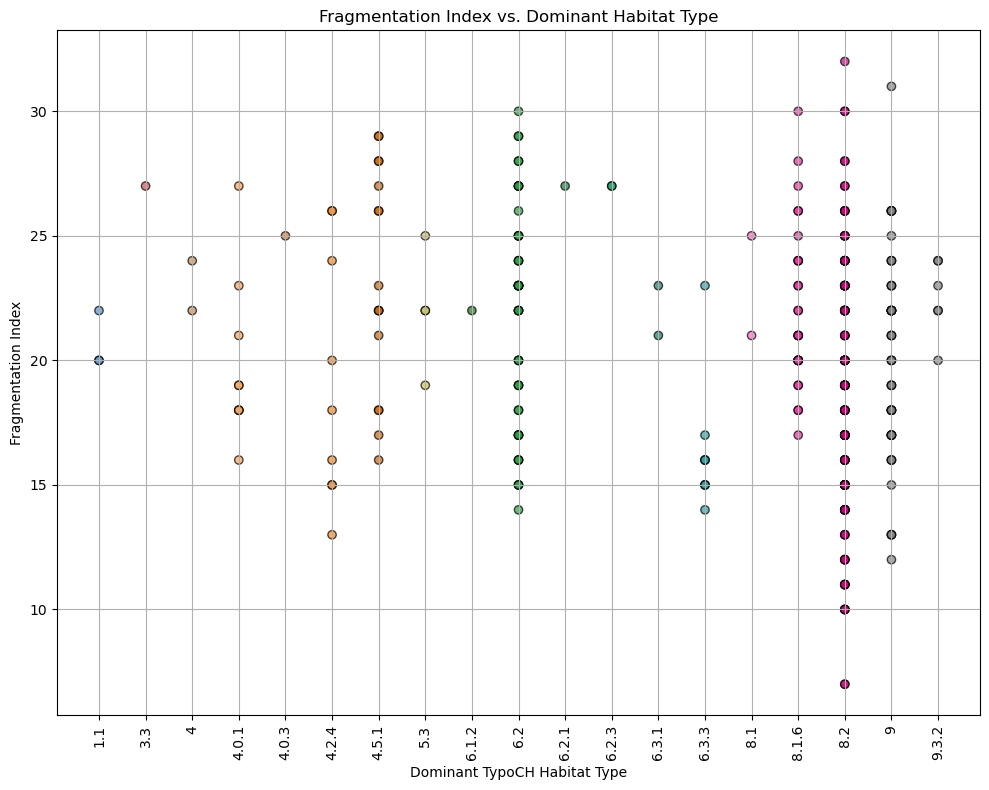

In [25]:
from src.utils import plot_fragmentation_dominant_type

plt = plot_fragmentation_dominant_type(buffers, habitat_palette)
plt.show()

In [26]:
print(buffers[buffers['buffer_id'] == 148]['fragmentation_index'])

147    29
Name: fragmentation_index, dtype: int64
